In [2]:
device = 'cuda'

In [3]:
import random
import numpy as np
import torch

In [4]:
def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed()


In [1]:
# hyperparameters
from sched import scheduler


batch_size = 64
n_worker = 24

image_size = 512
arch_name = 'tf_efficientnetv2_l.in21k'
epochs = 20
lr = 1e-4
drop_rate = 0.45
drop_path_rate = 0.1

loss_fn = "FocalLoss"
focal_alpha = 0.6
focal_gamma = 1.8
aux_loss = 'binary_cross_entropy'


loss1_coef = 1
optmizer = 'AdamW'
scheduler = 'CosineAnnealingWarmRestarts'
scheduler_warmup = None # "GradualWarmupSchedulerV3"
warmup_factor = 2
warmup_epo = 5
T_max = epochs - 1



In [7]:
import pandas as pd
train_label_image = pd.read_csv('./siim-covid19-detection/train_image_level.csv')
train_label_study = pd.read_csv('./siim-covid19-detection/train_study_level.csv')

# train_label

In [7]:
study_id = set()
boxes_study_id= set()
uniqued_train_label_image = pd.DataFrame(columns = train_label_image.columns)

for idx,image_id,boxes,label,StudyInstanceUID in train_label_image.itertuples():
    # break
    if StudyInstanceUID not in study_id:
        study_id.add(StudyInstanceUID)
        # check if opacity in label
        if label.find('none') == -1:
            boxes_study_id.add(StudyInstanceUID)
        # print(uniqued_train_label_image.columns)
        # print(train_label_image.iloc[idx])
        uniqued_train_label_image = uniqued_train_label_image.append(train_label_image.iloc[idx])
        # print(uniqued_train_label_image.columns)
        # break
    else:
        if StudyInstanceUID in boxes_study_id:
            continue
        elif label.find('none') == -1:
            boxes_study_id.add(StudyInstanceUID)
            uniqued_train_label_image.loc[uniqued_train_label_image['StudyInstanceUID'] == StudyInstanceUID] = [image_id,boxes,label,StudyInstanceUID]

uniqued_train_label_image = uniqued_train_label_image.reset_index(drop=True)

    
        

In [8]:
train_label_study['StudyInstanceUID'] = train_label_study['id'].apply(lambda x: x.replace('_study',''))

In [9]:
train_df = pd.merge(uniqued_train_label_image,train_label_study,on='StudyInstanceUID')

In [10]:
train_df.rename(columns={'id_x':'id_image'},inplace=True)
train_df.drop(['id_y'],axis=1,inplace=True)


In [11]:
train_df['id_image'] = train_df['id_image'].apply(lambda x: x.replace('_image',''))

In [12]:
train_df

,id_image,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0
...,...,...,...,...,...,...,...,...
6049,ffcc6edd9445,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0
6050,ffd91a2c4ca0,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0
6051,ffd9b6cf2961,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0
6052,ffdc682f7680,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0


In [13]:
train_df['filepath'] = './data/train/images/'+train_df['id_image']+'.png'

In [14]:
from sklearn.model_selection import GroupKFold
folds = GroupKFold(n_splits=5)

In [15]:
# add column for fold
train_df['fold_id'] = -1
for fold_id,(train_idx,valid_idx) in enumerate(folds.split(train_df,groups=train_df.StudyInstanceUID.tolist())):
    train_df.loc[valid_idx,'fold_id'] = fold_id

In [16]:
train_df

,id_image,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,filepath,fold_id
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,./data/train/images/000a312787f2.png,3
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,./data/train/images/000c3a3f293f.png,0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,./data/train/images/0012ff7358bc.png,2
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,./data/train/images/001398f4ff4f.png,2
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,./data/train/images/001bd15d1891.png,4
...,...,...,...,...,...,...,...,...,...,...
6049,ffcc6edd9445,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0,./data/train/images/ffcc6edd9445.png,4
6050,ffd91a2c4ca0,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0,./data/train/images/ffd91a2c4ca0.png,1
6051,ffd9b6cf2961,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0,./data/train/images/ffd9b6cf2961.png,0
6052,ffdc682f7680,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0,./data/train/images/ffdc682f7680.png,3


In [17]:
rotate_limit = 20
scale_limit = 0.7
shift_limit =  0.3
num_holes = 8
max_h_size = 0.05
max_w_size = 0.05

In [21]:
import albumentations
from albumentations.pytorch import ToTensorV2
from albumentations import RandomCrop,HorizontalFlip,VerticalFlip,Rotate,RandomBrightnessContrast,\
    RandomResizedCrop,Normalize,Resize,Compose,GaussianBlur,RandomBrightness,RandomContrast,RandomGamma,RandomRotate90,Transpose,\
    ShiftScaleRotate,Blur,OpticalDistortion,GridDistortion,HueSaturationValue,IAAAdditiveGaussianNoise,IAAPerspective,RandomSizedCrop,\
    RandomShadow,RandomSnow,RandomRain,RandomFog,CenterCrop,CoarseDropout,ChannelShuffle,ToGray,Cutout,PadIfNeeded,RandomCrop,VerticalFlip,HorizontalFlip,\
    Transpose,RandomRotate90,ShiftScaleRotate,ElasticTransform,GridDistortion,OpticalDistortion,RandomSizedCrop,HueSaturationValue,RGBShift,RandomBrightnessContrast,\
    RandomGamma,CLAHE,Blur,MedianBlur,MotionBlur,GaussNoise,GaussianBlur,RGBShift,RandomBrightnessContrast,IAAEmboss,IAASharpen,IAASuperpixels,RandomFog,RandomRain,\
    RandomShadow,RandomSnow,RandomSunFlare
transform_train = albumentations.Compose([
    RandomCrop(image_size,image_size),
    HorizontalFlip(p=0.5),
    ShiftScaleRotate(p=0.7,shift_limit=shift_limit,scale_limit=scale_limit,rotate_limit=rotate_limit),
    Cutout(p=0.7,num_holes=8,max_h_size=int(image_size*max_h_size),max_w_size=int(image_size*max_w_size))
    ],
    additional_targets={'mask':'image'})
transform_train_image = albumentations.Compose([
    RandomBrightnessContrast(p=0.1,brightness_limit=0.3,contrast_limit=0.3),
    HueSaturationValue(p=0.1,hue_shift_limit=20,sat_shift_limit=50,val_shift_limit=40),
    Normalize()])
transform_valid = albumentations.Compose([
    Resize(image_size,image_size),
    Normalize()],
)

transform_train()


/home/outerform/anaconda3/envs/ml/lib/python3.7/site-packages/albumentations/augmentations/dropout/cutout.py:51: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  FutureWarning,


KeyError: 'image'

In [47]:
import cv2
from PIL import Image
from torchvision.transforms import ToTensor,Normalize,Compose,Resize
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,df,transform=None,mode:str='train'):
        self.df = df
        self.transform = transform
        self.mode = mode
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        img = Image.open(row.filepath).convert('RGB')
        if self.mode == 'train':
            mask_img = Image.open(row.filepath.replace('train','train_mask')).convert('RGB')
            transformed = self.transform[0](image=np.array(img),mask=np.array(mask_img))
            mask_img = transformed['mask']
            img = self.transform[1](image=transformed['image'])['image']
            # print(row)
            label = torch.tensor(row[['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']]).float()
            return img,mask_img,label
        elif self.mode == 'valid':
            img = self.transform(image=np.array(img))['image']
            label = torch.tensor(row[['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']]).float()
            return img,label
        elif self.mode == 'test':
            img = self.transform(image=np.array(img))['image']
            return img
        else:
            raise ValueError('mode must be train or valid or test')
        

In [48]:
train_dataset = MyDataset(train_df,transform=[transform_train,transform_train_image],mode='train')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

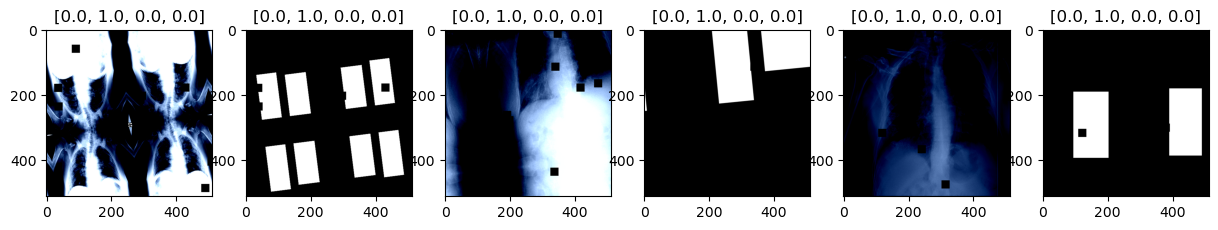

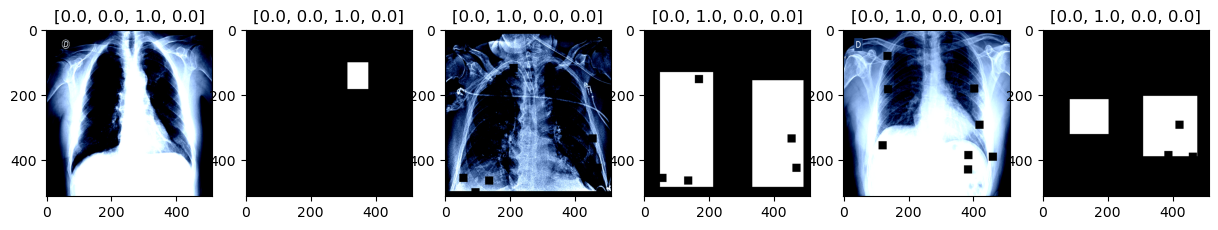

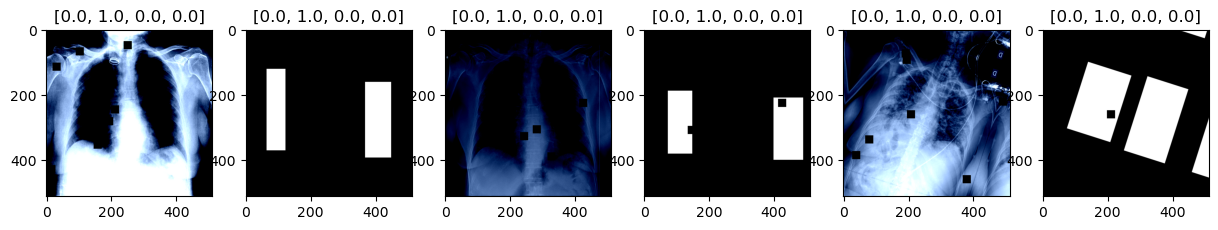

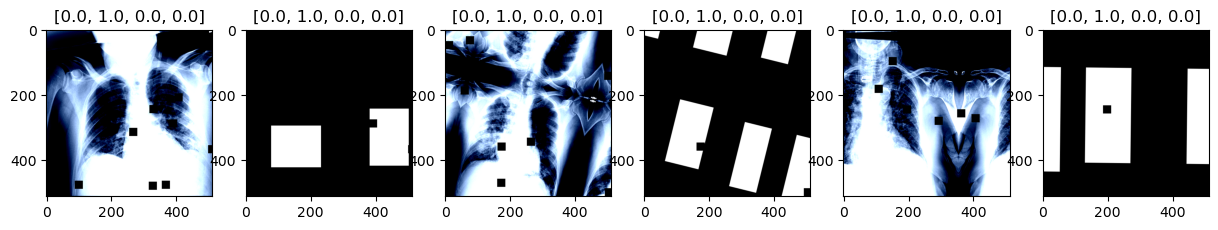

In [49]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,5
for i in range(4):
    f, axarr = plt.subplots(1,6)
    for p in range(0,6,2):
        idx = i*5 + p
        img, mask_img, label = train_dataset[idx]
        # img = img.transpose(2,1,0)
        # print(img.shape,mask_img.shape,label)
        # plt.imshow(img)
        axarr[p].imshow(img)
        axarr[p+1].imshow(mask_img)
        axarr[p].set_title(label.tolist())
        axarr[p+1].set_title(label.tolist())

Model

In [45]:
from torch import adaptive_max_pool1d
from torch.utils.data import DataLoader
#effnetv2
import torch.nn as nn
import timm
from torch.nn import functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.nn import AvgPool2d,AdaptiveAvgPool2d

class Swish(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)
        
class Effnetv2(nn.Module):
    def __init__(self,pretrained=True):
        super().__init__()
        self.model = timm.create_model(arch_name,pretrained=pretrained,num_classes=4,drop_rate = drop_rate,drop_path_rate=drop_path_rate)
        self.logit = nn.Linear(self.model.classifier.in_features,4)
        self.preprocess = nn.Sequential(
            self.model.conv_stem,
            self.model.bn1,
            Swish()
        )
        self.blocks = self.model.blocks
        self.mask = nn.Sequential(
            nn.Conv2d(224, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1, padding=0),
        )
        self.classifier = nn.Sequential(
             self.model.conv_head,
                self.model.bn2,
                Swish(),
        )



    def forward(self,x):
        batch_size = len(x)
        x = self.preprocess(x)
        for block in self.blocks[:5]:
            x = block(x)
        mask = self.mask(x)
        for block in self.blocks[5:]:
            x = block(x)
        x = AdaptiveAvgPool2d((1,1))(x)
        x = self.classifier(x)

In [2]:
from enum import auto
from torch.optim import AdamW
from torch.cuda.amp import GradScaler,autocast
from tqdm.auto import tqdm
scaler = GradScaler()
class Trainer:
    def __init__(self,model,train_dataloader, valid_dataloader) -> None:
        self.model = model

    def accuracy(outputs,targets):
        outputs = torch.argmax(outputs,dim=1)
        return (outputs == targets).float().mean()
    
    def train(self,train_dataloader,opt = 'AdamW',lr = 1e-3,weight_decay = 1e-6, loss_fn = "BCEWithLogitsLoss",aux_loss = "binary_cross_entropy",_scheduler = 'CosineAnnealingLR',T_max = 10,eta_min = 1e-6,valid_dataloader = None,device = 'cuda:0'):
        if opt == 'AdamW':
            optimizer = AdamW(self.model.parameters(),lr=lr/warmup_factor
                              ,weight_decay=weight_decay)
        if loss_fn == 'BCEWithLogitsLoss':
            criterion = nn.BCEWithLogitsLoss()
        elif loss_fn == 'CrossEntropyLoss':
            criterion = nn.CrossEntropyLoss()
        else:
            raise ValueError('loss_fn must be BCEWithLogitsLoss or CrossEntropyLoss')
        
        if aux_loss == 'binary_cross_entropy':
            aux_criterion = F.binary_cross_entropy_with_logits
        else:
            raise ValueError('aux_loss must be binary_cross_entropy')
        model=self.model
        model.train()
        losses = []
        accs = []
        for idx,(img,mask_img,label) in tqdm(enumerate(train_dataloader),total=len(train_dataloader)):
            img = img.to(device)
            mask_img = mask_img.to(device)
            label = label.to(device)
            with autocast():
                optimizer.zero_grad()
                pred = model(img)
                if loss_fn == 'BCEWithLogitsLoss':
                    loss = criterion(pred,label)
                elif loss_fn == 'CrossEntropyLoss':
                    loss = criterion(pred,label.argmax(-1))
                else:
                    raise ValueError('loss_fn must be BCEWithLogitsLoss or CrossEntropyLoss')
                loss1 = aux_criterion(pred,mask_img)*loss1_coef
                scaler.scale(loss+loss1).backward()
                scaler.step(optimizer)
                scaler.update()
                accs.append(self.accuracy(pred,label))
                losses.append([loss.item(),loss1.item()])
                if idx % 100 == 0:
                    tqdm.set_postfix(loss=loss.item(),acc=accs[-1])
                    # (f'idx:{idx},loss:{np.mean(losses)},acc:{np.mean(accs)}')
        return losses,accs,optimizer

    def valid(self,valid_dataloader,loss_fn = "BCEWithLogitsLoss",device = 'cuda:0'):
        model = self.model
        model.eval()
        losses = []
        accs = []
        preds = []
        if loss_fn == 'BCEWithLogitsLoss':
            criterion = nn.BCEWithLogitsLoss()
        elif loss_fn == 'CrossEntropyLoss':
            criterion = nn.CrossEntropyLoss()
        else:
            raise ValueError('loss_fn must be BCEWithLogitsLoss or CrossEntropyLoss')

        for idx,(img,mask_img,label) in tqdm(enumerate(valid_dataloader),total=len(valid_dataloader)):
            img = img.to(device)
            mask_img = mask_img.to(device)
            label = label.to(device)
            with torch.no_grad():
                pred = model(img)
                if loss_fn == 'BCEWithLogitsLoss':
                    loss = criterion(pred,label)
                elif loss_fn == 'CrossEntropyLoss':
                    loss = criterion(pred,label.argmax(-1))
                else:
                    raise ValueError('loss_fn must be BCEWithLogitsLoss or CrossEntropyLoss')
                # accuracy = lambda x,y: (x.argmax(-1) == y.argmax(-1)).float().mean()
                accs.append(self.accuracy(pred,label))
                losses.append(loss.item())
                preds.append(pred.cpu().numpy())
        return losses,accs,np.concatenate(preds,axis=0)

        
        

In [44]:
from math import e


def get_dataloader(fold,df):
    train_df = df[df.fold != fold]
    valid_df = df[df.fold == fold]
    train_dataset = MyDataset(train_df)
    valid_dataset = MyDataset(valid_df)
    train_dataloader = DataLoader(train_dataset,batch_size=bs,shuffle=True,num_workers=4,pin_memory=True)
    valid_dataloader = DataLoader(valid_dataset,batch_size=bs,shuffle=False,num_workers=4,pin_memory=True)

    return train_dataloader,valid_dataloader
for fold in range(5):
    train_dataloader,valid_dataloader = get_dataloader(fold,train_df)
    model = Effnetv2()
    model.to(device)
    trainer = Trainer(model,train_dataloader,valid_dataloader)
    for epoch in range(epochs):
        train_losses,train_accs,optimizer = trainer.train(train_dataloader,valid_dataloader=valid_dataloader,device=device,loss_fn=loss_fn,aux_loss=aux_loss,lr=lr,_scheduler=scheduler,T_max=T_max)
        valid_losses,valid_accs,valid_preds = trainer.valid(valid_dataloader,device=device,loss_fn=loss_fn)
        print(f'epoch:{epoch},train_loss:{np.mean(train_losses)},train_acc:{np.mean(train_accs)},valid_loss:{np.mean(valid_losses)},valid_acc:{np.mean(valid_accs)}')
        torch.save(model.state_dict(),f'./model_{fold}_{epoch}.pth')


Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

In [30]:
for x in timm.list_models(pretrained=True):
    if x.find('efficientnetv2') != -1:
        print(x)

efficientnetv2_rw_m.agc_in1k
efficientnetv2_rw_s.ra2_in1k
efficientnetv2_rw_t.ra2_in1k
gc_efficientnetv2_rw_t.agc_in1k
tf_efficientnetv2_b0.in1k
tf_efficientnetv2_b1.in1k
tf_efficientnetv2_b2.in1k
tf_efficientnetv2_b3.in1k
tf_efficientnetv2_b3.in21k
tf_efficientnetv2_b3.in21k_ft_in1k
tf_efficientnetv2_l.in1k
tf_efficientnetv2_l.in21k
tf_efficientnetv2_l.in21k_ft_in1k
tf_efficientnetv2_m.in1k
tf_efficientnetv2_m.in21k
tf_efficientnetv2_m.in21k_ft_in1k
tf_efficientnetv2_s.in1k
tf_efficientnetv2_s.in21k
tf_efficientnetv2_s.in21k_ft_in1k
tf_efficientnetv2_xl.in21k
tf_efficientnetv2_xl.in21k_ft_in1k
